# Import Modules

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from copy import deepcopy
##
# from lib import my_draw_networkx_edge_labels

In [ ]:
def my_draw_networkx_edge_labels(
    G,
    pos,
    edge_labels=None,
    label_pos=0.5,
    font_size=10,
    font_color="k",
    font_family="sans-serif",
    font_weight="normal",
    alpha=None,
    bbox=None,
    horizontalalignment="center",
    verticalalignment="center",
    ax=None,
    rotate=True,
    clip_on=True,
    rad=0
):
    """Draw edge labels.

    Parameters
    ----------
    G : graph
        A networkx graph

    pos : dictionary
        A dictionary with nodes as keys and positions as values.
        Positions should be sequences of length 2.

    edge_labels : dictionary (default={})
        Edge labels in a dictionary of labels keyed by edge two-tuple.
        Only labels for the keys in the dictionary are drawn.

    label_pos : float (default=0.5)
        Position of edge label along edge (0=head, 0.5=center, 1=tail)

    font_size : int (default=10)
        Font size for text labels

    font_color : string (default='k' black)
        Font color string

    font_weight : string (default='normal')
        Font weight

    font_family : string (default='sans-serif')
        Font family

    alpha : float or None (default=None)
        The text transparency

    bbox : Matplotlib bbox, optional
        Specify text box properties (e.g. shape, color etc.) for edge labels.
        Default is {boxstyle='round', ec=(1.0, 1.0, 1.0), fc=(1.0, 1.0, 1.0)}.

    horizontalalignment : string (default='center')
        Horizontal alignment {'center', 'right', 'left'}

    verticalalignment : string (default='center')
        Vertical alignment {'center', 'top', 'bottom', 'baseline', 'center_baseline'}

    ax : Matplotlib Axes object, optional
        Draw the graph in the specified Matplotlib axes.

    rotate : bool (deafult=True)
        Rotate edge labels to lie parallel to edges

    clip_on : bool (default=True)
        Turn on clipping of edge labels at axis boundaries

    Returns
    -------
    dict
        `dict` of labels keyed by edge

    Examples
    --------
    >>> G = nx.dodecahedral_graph()
    >>> edge_labels = nx.draw_networkx_edge_labels(G, pos=nx.spring_layout(G))

    Also see the NetworkX drawing examples at
    https://networkx.org/documentation/latest/auto_examples/index.html

    See Also
    --------
    draw
    draw_networkx
    draw_networkx_nodes
    draw_networkx_edges
    draw_networkx_labels
    """
    import matplotlib.pyplot as plt
    import numpy as np

    if ax is None:
        ax = plt.gca()
    if edge_labels is None:
        labels = {(u, v): d for u, v, d in G.edges(data=True)}
    else:
        labels = edge_labels
    text_items = {}
    for (n1, n2), label in labels.items():
        (x1, y1) = pos[n1]
        (x2, y2) = pos[n2]
        (x, y) = (
            x1 * label_pos + x2 * (1.0 - label_pos),
            y1 * label_pos + y2 * (1.0 - label_pos),
        )
        pos_1 = ax.transData.transform(np.array(pos[n1]))
        pos_2 = ax.transData.transform(np.array(pos[n2]))
        linear_mid = 0.5*pos_1 + 0.5*pos_2
        d_pos = pos_2 - pos_1
        rotation_matrix = np.array([(0,1), (-1,0)])
        ctrl_1 = linear_mid + rad*rotation_matrix@d_pos
        ctrl_mid_1 = 0.5*pos_1 + 0.5*ctrl_1
        ctrl_mid_2 = 0.5*pos_2 + 0.5*ctrl_1
        bezier_mid = 0.5*ctrl_mid_1 + 0.5*ctrl_mid_2
        (x, y) = ax.transData.inverted().transform(bezier_mid)

        if rotate:
            # in degrees
            angle = np.arctan2(y2 - y1, x2 - x1) / (2.0 * np.pi) * 360
            # make label orientation "right-side-up"
            if angle > 90:
                angle -= 180
            if angle < -90:
                angle += 180
            # transform data coordinate angle to screen coordinate angle
            xy = np.array((x, y))
            trans_angle = ax.transData.transform_angles(
                np.array((angle,)), xy.reshape((1, 2))
            )[0]
        else:
            trans_angle = 0.0
        # use default box of white with white border
        if bbox is None:
            bbox = dict(boxstyle="round", ec=(1.0, 1.0, 1.0), fc=(1.0, 1.0, 1.0))
        if not isinstance(label, str):
            label = str(label)  # this makes "1" and 1 labeled the same

        t = ax.text(
            x,
            y,
            label,
            size=font_size,
            color=font_color,
            family=font_family,
            weight=font_weight,
            alpha=alpha,
            horizontalalignment=horizontalalignment,
            verticalalignment=verticalalignment,
            rotation=trans_angle,
            transform=ax.transData,
            bbox=bbox,
            zorder=1,
            clip_on=clip_on,
        )
        text_items[(n1, n2)] = t

    ax.tick_params(
        axis="both",
        which="both",
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False,
    )

    return text_items

# Ant Colony System

In [ ]:
class Ant:
    complete_step = None
    alpha = 1
    beta = 1
    decay = 0.95
    start = None
    current = None
    visited = None
    num_visited = None
    tour = None
    tour_distance = None
    finished = None
    def __init__(self, complete_step = 0, start = None, alpha = 1, beta = 1, decay = 0.95): ## complete_step = n+1
        if alpha >= 0:
            self.alpha = alpha
        else:
            self.beta = 1
        if alpha >= 0:
            self.beta = beta
        else:
            self.beta = 1
        if decay > 0 and decay < 1:
            self.decay = decay
        else:
          self.decay = 0.95
        self.finished = False
        self.tour_distance = 0
        self.complete_step = complete_step
        self.visited = set()
        self.num_visited = 0
        self.tour = []
        self.tour_distance = 0
        if start:
            self.visit(start)
    def run(self, map, exploitation = False, q0 = None):
        return self.build_shortest_path(map = map, exploitation = exploitation, q0 = q0)
    def has_visited(self, pos):
        return pos not in self.visited
    def allow_to_visit(self, list_of_position):
        return list_of_position.difference(self.visited)
    def visit(self, pos, distance = 0):
        ## check if this position is valid to visit
        if not self.has_visited(pos):
            return False
        self.visited.add(pos)
        self.tour.append(pos)
        self.tour_distance += distance
        self.current = pos
        if self.current == self.start:  ## initial: self.start = None
            self.finished = True
        else:
            if len(self.visited) == 1:
                self.start = pos
            self.num_visited += 1
            if self.num_visited == self.complete_step:
                self.visited.discard(self.start)
        return True
    def greedy_heuristic(self, adjcency_map, pheromone = 't', distance = 'd'):
        arg, max = None, None
        for pos in adjcency_map:
          temp = adjcency_map[pos][pheromone] ** self.alpha * (1.0 / adjcency_map[pos][distance]) ** self.beta
          if not arg or temp > max:
              max = temp
              arg = pos
        return arg
    def transition_probability(self, adjcency_map, pheromone = 't', distance = 'd'):
        arg, max = None, None
        adj = []
        probability = []
        for pos in adjcency_map:
          adj.append(pos)
          temp = adjcency_map[pos][pheromone] ** self.alpha * (1.0 / adjcency_map[pos][distance]) ** self.beta
          probability.append(temp)
        total = sum(probability)
        norm = [prob / total for prob in probability]
        if not adj:
          return arg
        arg = np.random.choice(adj, 1, p = norm)[0]
        return arg
    def exploitation(self, adjcency_map, distance = 'd', global_visited = 'g'):
        allowed_visit = {pos:adjcency_map[pos] for pos in adjcency_map if not adjcency_map[pos][global_visited]}
        pos = self.greedy_heuristic(adjcency_map = allowed_visit)
        # if pos:
            # return None, None
        return pos, allowed_visit[pos][distance]
    def biased_exploration(self, adjcency_map, distance = 'd'):
        allowed_visit = {pos:adjcency_map[pos] for pos in adjcency_map if pos not in self.visited}
        pos = self.transition_probability(adjcency_map = allowed_visit)
        # if pos:
            # return None, None
        return pos, allowed_visit[pos][distance]
    def build_shortest_path(self, map, exploitation = False, q0 = None):
        if exploitation:
            if not q0:
                q0 = np.random.random()
        for step in range(self.complete_step):
            if exploitation:
                q = np.random.random()
                if q<=q0:
                    next, distance = self.exploitation(adjcency_map = map.adj[self.current])
                    if next == None:
                        next, distance = self.biased_exploration(adjcency_map = map.adj[self.current])
                else:
                    next, distance = self.biased_exploration(adjcency_map = map.adj[self.current])
                    if next == None:
                        break
            else:
                next, distance = self.biased_exploration(adjcency_map = map.adj[self.current])
                if next == None:
                    break
            self.visit(next, distance)
            if self.finished:
                break
        if not self.finished:
            return None, None
        return self.tour, self.tour_distance

In [ ]:
class AntColony:
    ## global
    num_positions = None
    posisions = None
    graph = None
    alpha = 1
    beta = 1
    decay = 0.95  ## 0.05
    time_out = None
    ## local
    num_ants = None
    ants = None
    max_ant_id = 0
    distribution_style = None ## distribution_style = {'1_1' : each 1 position at least 1 ant; '1_n': each position has random ants}:
    b = None
    def __init__(self, graph, num_ants = None, distribution_style = '1_n', alpha = 1, beta = 1, decay = 0.95):
        ##
        self.graph = graph
        self.parse_graph()
        if alpha >= 0:
            self.alpha = alpha
        else:
            self.beta = 1
        if alpha >= 0:
            self.beta = beta
        else:
            self.beta = 1
        if decay > 0 and decay < 1:
            self.decay = decay
        else:
          self.decay = 0.95
    def parse_graph(self):
        if self.graph:
            self.num_positions = self.graph.number_of_nodes()
            self.posisions = list(self.graph.nodes)
    def global_visit(self, global_visit = 'g'):
        for e in self.graph.edges():
            self.graph[e[0]][e[1]][global_visit] = False
    def ants_distribution(self, num_ants = None, distribution_style = '1_1'):
        ## reset ants
        self.ants = {}
        self.max_ant_id = 0
        self.global_visit(global_visit = 'g')
        ##
        if num_ants and 0 < num_ants:
            self.num_ants = num_ants
            if self.num_ants == self.num_positions and distribution_style == '1_1':
                self.distribution_style = '1_1'
            else:
                self.distribution_style = '1_n'
        else:
            self.num_ants = self.num_positions
            self.distribution_style = '1_n'
        ##
        num_positions = self.num_positions
        posisions = self.posisions
        num_ants = self.num_ants
        shuffle = [pos for pos in self.posisions]
        self.b = {pos:set() for pos in self.posisions}
        ## 1_1
        if self.distribution_style == '1_1':
            for pos in shuffle:
                # ant = Ant(num_positions = self.num_positions, posisions = self.posisions, start = pos)
                ant = Ant(complete_step = self.num_positions, start = pos)
                ant_id = self.max_ant_id
                self.max_ant_id += 1
                self.ants[self.ant_id] = ant
                self.b[pos].add(ant_id)
                num_ants -= 1
        ##  1_n
        np.random.shuffle(shuffle)
        iter = 0
        while num_ants > 0:
            if iter >= num_positions:
                np.random.shuffle(shuffle)
                iter = 0
            pos = shuffle[iter]
            num_ants_distributed = np.random.randint(0, num_ants + 1)
            while num_ants_distributed > 0:
                ant  = Ant(complete_step = num_positions, start = pos)
                ant_id = self.max_ant_id
                self.max_ant_id += 1
                self.ants[ant_id] = ant
                self.b[pos].add(ant_id)
                num_ants -= 1
                num_ants_distributed -= 1
    def init_spread_pheromone(self, pheromone = 't', c = 0.001):
        for e in self.graph.edges():
            self.graph[e[0]][e[1]][pheromone] = c
            # print(f'{e}, {graph[e[0]][e[1]]}')
    def spread_pheromone(self, best_iter_tour_distance = 1.0, decay = 0.95, pheromone = 't'):
        for e in self.graph.edges():
            self.graph[e[0]][e[1]][pheromone] += 1.0 / best_iter_tour_distance
            self.graph[e[0]][e[1]][pheromone] *= decay
    def run(self, n_iteration = 100, num_ants = 1, distribution_style = '1_1', distance = 'd', pheromone = 't', global_visit = 'g', c = 0.0001):
        self.all_time_shortest_path = ("", np.inf)
        for iter in range(n_iteration):
            ## parallel (?)
            self.ants_distribution(num_ants = num_ants, distribution_style = distribution_style)
            self.init_spread_pheromone(pheromone = pheromone, c = c)
            ## find tour
            all_paths = []
            for ant in self.ants:
                tour, tour_distance = self.ants[ant].run(map = self.graph)
                if tour == None:
                    continue
                all_paths.append((tour, tour_distance))
                print(f'Iteration [{iter}]: Ant [{ant}] -- Tour : {tour} -- Distance : {tour_distance}')
            ## end find tour
            best_tour, best_iter_tour_distance = sorted(all_paths, key=lambda x: x[1])[0]
            print(f'Iteration [{iter}]: Best tour found: {best_tour} -- Best tour distance: {best_iter_tour_distance}')
            ## spread pheromone
            self.spread_pheromone(best_iter_tour_distance = best_iter_tour_distance, pheromone = pheromone)
            shortest_path = min(all_paths, key=lambda x: x[1])
            ## update
            if shortest_path[1] == self.all_time_shortest_path[1]:  ## stop condition
                print(f'Iteration [{iter}]: All time best tour found: {self.all_time_shortest_path[0]} -- All time best tour distance: {self.all_time_shortest_path[1]}')
                break
            elif shortest_path[1] < self.all_time_shortest_path[1]:
                self.all_time_shortest_path = shortest_path
            print(f'Iteration [{iter}]: All time best tour found: {self.all_time_shortest_path[0]} -- All time best tour distance: {self.all_time_shortest_path[1]}')
        return self.all_time_shortest_path
    # def run(self, n_iteration = 100, num_ants = 10):
    #     # self.ants = {}
    #     # self.ants_distribution()
    #     # self.init_spread_pheromone(pheromone = 't', c = 0.001)
    #     self.all_time_shortest_path = ("", np.inf)
    #     ## alg
    #     for iter in range(n_iteration):
    #         ## parallel (?)
    #         self.ants = {}
    #         self.max_ant_id = 0
    #         self.ants_distribution()
    #         self.init_spread_pheromone(pheromone = 't', c = 0.001)
    #         ## find tour
    #         all_paths = []
    #         for ant in self.ants:
    #             # tour, tour_distance = self.ants[ant].shortest_path()
    #             tour, tour_distance = self.ants[ant].run(map = self.graph)
    #             all_paths.append((tour, tour_distance))
    #             print(f'Iteration [{iter}]: Ant [{ant}] -- Tour : {tour} -- Distance : {tour_distance}')
    #         ##
    #         best_tour, best_iter_tour_distance = sorted(all_paths, key=lambda x: x[1])[0]
    #         print(f'Iteration [{iter}]: Best tour found: {best_tour} -- Best tour distance: {best_iter_tour_distance}')
    #         ## spread pheromone
    #         self.spread_pheromone(best_iter_tour_distance = best_iter_tour_distance, pheromone = 't')
    #         shortest_path = min(all_paths, key=lambda x: x[1])
    #         if shortest_path[1] == self.all_time_shortest_path[1]:  ## stop condition
    #             print(f'Iteration [{iter}]: All time best tour found: {self.all_time_shortest_path[0]} -- All time best tour distance: {self.all_time_shortest_path[1]}')
    #             break
    #         elif shortest_path[1] < self.all_time_shortest_path[1]:
    #             self.all_time_shortest_path = shortest_path
    #         print(f'Iteration [{iter}]: All time best tour found: {self.all_time_shortest_path[0]} -- All time best tour distance: {self.all_time_shortest_path[1]}')
    #     return self.all_time_shortest_path

In [ ]:
# # G = G1
# ac = AntColony(graph = G1, num_ants = 10)
# shortest_path = ac.run(n_iteration = 100)
# shortest_path

In [ ]:
# # G = G2
# ac2 = AntColony( graph = G2, num_ants = 10)
# shortest_path = ac2.run(n_iteration = 100)
# shortest_path

# Import Datasets

Dataset: Graph-type = {'directed', 'undirected', 'adjaceccy-matrix', 'randomize', 'Euclide'}

In [ ]:
G1 = nx.read_gml("complete_graph_undirected.gml")
G1.nodes, G1.edges, G1.adj

(NodeView(('0', '1', '2', '3', '4')),
 EdgeView([('0', '1'), ('0', '2'), ('0', '3'), ('0', '4'), ('1', '2'), ('1', '3'), ('1', '4'), ('2', '3'), ('2', '4'), ('3', '4')]),
 AdjacencyView({'0': {'1': {'d': 9}, '2': {'d': 4}, '3': {'d': 2}, '4': {'d': 6}}, '1': {'0': {'d': 9}, '2': {'d': 10}, '3': {'d': 4}, '4': {'d': 10}}, '2': {'0': {'d': 4}, '1': {'d': 10}, '3': {'d': 3}, '4': {'d': 9}}, '3': {'0': {'d': 2}, '1': {'d': 4}, '2': {'d': 3}, '4': {'d': 6}}, '4': {'0': {'d': 6}, '1': {'d': 10}, '2': {'d': 9}, '3': {'d': 6}}}))

{('0', '1'): 9, ('0', '2'): 4, ('0', '3'): 2, ('0', '4'): 6, ('1', '2'): 10, ('1', '3'): 4, ('1', '4'): 10, ('2', '3'): 3, ('2', '4'): 9, ('3', '4'): 6}


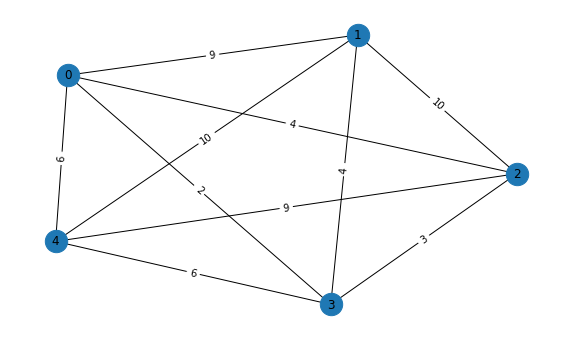

In [ ]:
plt.figure(figsize=(10,6))
pos = nx.spring_layout(G1, seed=7) ## seed=7
## draw nodes
nx.draw_networkx_nodes(G1, pos, node_size = 500)
## draw node labels
nx.draw_networkx_labels(G1, pos)
## draw edges
arc_rad = 0.1
edge_list = [edge for edge in G1.edges(data=True)]
nx.draw_networkx_edges(G1, pos, edgelist = edge_list)
# edge distance labels
edge_labels = nx.get_edge_attributes(G1, "d")
print(edge_labels)
nx.draw_networkx_edge_labels(G1, pos, edge_labels = edge_labels)
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.show()

In [ ]:
G2 = nx.read_gml("complete_graph_directed.gml")
G2.adj

AdjacencyView({'0': {'1': {'d': 8}, '2': {'d': 8}, '3': {'d': 3}, '4': {'d': 3}}, '1': {'0': {'d': 3}, '2': {'d': 2}, '3': {'d': 8}, '4': {'d': 7}}, '2': {'0': {'d': 7}, '1': {'d': 10}, '3': {'d': 6}, '4': {'d': 7}}, '3': {'0': {'d': 1}, '1': {'d': 8}, '2': {'d': 5}, '4': {'d': 9}}, '4': {'0': {'d': 1}, '1': {'d': 9}, '2': {'d': 7}, '3': {'d': 1}}})

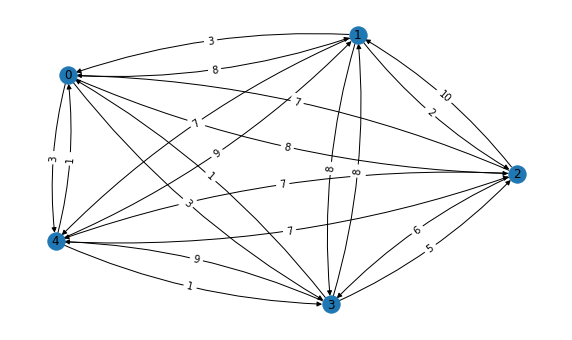

In [ ]:
plt.figure(figsize=(10,6))
pos = nx.spring_layout(G2, seed=7) ## seed=7
## draw nodes
nx.draw_networkx_nodes(G2, pos, node_size = 300)
## draw node labels
nx.draw_networkx_labels(G2, pos)
## draw edges
arc_rad = 0.1
# edge_list = [(u, v) for (u, v, d) in G2.edges(data=True)]
straight_edges = [edge for edge in G2.edges() if reversed(edge) not in G2.edges()] # straight_edges = list(set(G2.edges()) - set(curved_edges))
curved_edges = [edge for edge in G2.edges() if reversed(edge) in G2.edges()]
nx.draw_networkx_edges(G2, pos, edgelist = straight_edges)
nx.draw_networkx_edges(G2, pos, edgelist = curved_edges, connectionstyle=f'arc3, rad = {arc_rad}')
# edge distance labels
edge_labels = nx.get_edge_attributes(G2, "d")
straight_edge_labels = {edge: edge_labels[edge] for edge in straight_edges}
curved_edge_labels = {edge: edge_labels[edge] for edge in curved_edges}
nx.draw_networkx_edge_labels(G2, pos, edge_labels = straight_edge_labels)
# nx.draw_networkx_edge_labels(G2, pos, edge_labels = curved_edge_labels, label_pos=0.7)
my_draw_networkx_edge_labels(G2, pos, edge_labels = curved_edge_labels, rad = arc_rad)
# nx.draw_networkx_edge_labels(G2, pos, edge_labels = edge_labels, label_pos=0.3, font_size=7)

for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.show()

In [ ]:
G3 = nx.read_gml("example_tsp_undirected.gml")
G3.adj

AdjacencyView({'0': {'1': {'d': 2}, '4': {'d': 1}, '6': {'d': 2}}, '1': {'0': {'d': 2}, '2': {'d': 2}, '6': {'d': 5}}, '4': {'0': {'d': 1}, '2': {'d': 1}}, '6': {'0': {'d': 2}, '1': {'d': 5}, '3': {'d': 5}, '5': {'d': 4}}, '2': {'1': {'d': 2}, '4': {'d': 1}, '3': {'d': 2}}, '3': {'6': {'d': 5}, '2': {'d': 2}, '5': {'d': 3}}, '5': {'6': {'d': 4}, '3': {'d': 3}}})

{('0', '1'): 2, ('0', '4'): 1, ('0', '6'): 2, ('1', '2'): 2, ('1', '6'): 5, ('4', '2'): 1, ('6', '3'): 5, ('6', '5'): 4, ('2', '3'): 2, ('3', '5'): 3}


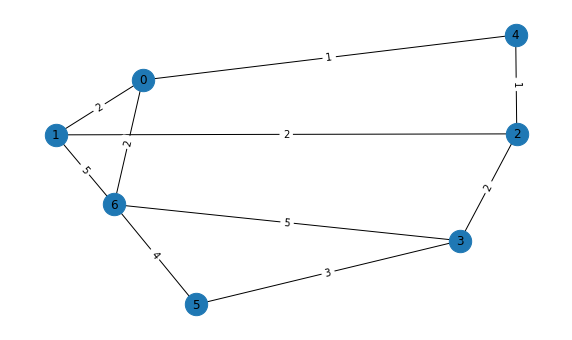

In [ ]:
plt.figure(figsize=(10,6))
pos = nx.spring_layout(G3, seed=7) ## seed=7
## draw nodess
nx.draw_networkx_nodes(G3, pos, node_size = 500)
## draw node labels
nx.draw_networkx_labels(G3, pos)
## draw edges
arc_rad = 0.1
edge_list = [edge for edge in G3.edges(data=True)]
nx.draw_networkx_edges(G3, pos, edgelist = edge_list)
# edge distance labels
edge_labels = nx.get_edge_attributes(G3, "d")
print(edge_labels)
nx.draw_networkx_edge_labels(G3, pos, edge_labels = edge_labels)
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.show()

In [ ]:
G4 = nx.read_gml("example_tsp_directed.gml")
G4.adj

AdjacencyView({'0': {'1': {'d': 2}, '4': {'d': 1}, '6': {'d': 2}}, '1': {'2': {'d': 2}, '6': {'d': 5}, '0': {'d': 2}}, '4': {'0': {'d': 1}, '2': {'d': 2}}, '6': {'0': {'d': 2}, '1': {'d': 7}, '3': {'d': 5}, '5': {'d': 4}}, '2': {'3': {'d': 3}, '4': {'d': 1}, '1': {'d': 3}}, '3': {'5': {'d': 4}, '6': {'d': 7}, '2': {'d': 2}}, '5': {'6': {'d': 4}, '3': {'d': 3}}})

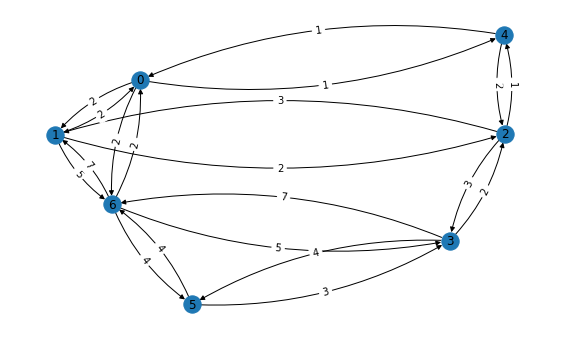

In [ ]:
plt.figure(figsize=(10,6))
pos = nx.spring_layout(G4, seed=7) ## seed=7
## draw nodes
nx.draw_networkx_nodes(G4, pos, node_size = 300)
## draw node labels
nx.draw_networkx_labels(G4, pos)
## draw edges
arc_rad = 0.15
# edge_list = [(u, v) for (u, v, d) in G4.edges(data=True)]
straight_edges = [edge for edge in G4.edges() if reversed(edge) not in G4.edges()] # straight_edges = list(set(G2.edges()) - set(curved_edges))
curved_edges = [edge for edge in G4.edges() if reversed(edge) in G4.edges()]
nx.draw_networkx_edges(G4, pos, edgelist = straight_edges)
nx.draw_networkx_edges(G4, pos, edgelist = curved_edges, connectionstyle=f'arc3, rad = {arc_rad}')
# edge distance labels
edge_labels = nx.get_edge_attributes(G4, "d")
straight_edge_labels = {edge: edge_labels[edge] for edge in straight_edges}
curved_edge_labels = {edge: edge_labels[edge] for edge in curved_edges}
nx.draw_networkx_edge_labels(G4, pos, edge_labels = straight_edge_labels)
# nx.draw_networkx_edge_labels(G4, pos, edge_labels = curved_edge_labels, label_pos=0.7)
my_draw_networkx_edge_labels(G4, pos, edge_labels = curved_edge_labels, rad = arc_rad)
# nx.draw_networkx_edge_labels(G4, pos, edge_labels = edge_labels, label_pos=0.3, font_size=7)

for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.show()

# Complete graph: undirected

In [ ]:
ac = AntColony(graph = G1)
shortest_path = ac.run(num_ants = 10, n_iteration = 100)

Iteration [0]: Ant [0] -- Tour : ['2', '3', '1', '4', '0', '2'] -- Distance : 27
Iteration [0]: Ant [1] -- Tour : ['2', '1', '0', '3', '4', '2'] -- Distance : 36
Iteration [0]: Ant [2] -- Tour : ['2', '0', '3', '1', '4', '2'] -- Distance : 29
Iteration [0]: Ant [3] -- Tour : ['2', '0', '1', '3', '4', '2'] -- Distance : 32
Iteration [0]: Ant [4] -- Tour : ['2', '3', '0', '4', '1', '2'] -- Distance : 31
Iteration [0]: Ant [5] -- Tour : ['2', '0', '4', '1', '3', '2'] -- Distance : 27
Iteration [0]: Ant [6] -- Tour : ['2', '1', '0', '3', '4', '2'] -- Distance : 36
Iteration [0]: Ant [7] -- Tour : ['2', '4', '1', '0', '3', '2'] -- Distance : 33
Iteration [0]: Ant [8] -- Tour : ['2', '4', '3', '0', '1', '2'] -- Distance : 36
Iteration [0]: Ant [9] -- Tour : ['2', '3', '0', '4', '1', '2'] -- Distance : 31
Iteration [0]: Best tour found: ['2', '3', '1', '4', '0', '2'] -- Best tour distance: 27
Iteration [0]: All time best tour found: ['2', '3', '1', '4', '0', '2'] -- All time best tour distanc

In [ ]:
# from multithread import MultipleThreading

# Complete graph: directed

In [ ]:
ac2 = AntColony(graph = G2, num_ants = 10)
shortest_path = ac2.run(num_ants = 10, n_iteration = 100)

Iteration [0]: Ant [0] -- Tour : ['1', '3', '0', '4', '2', '1'] -- Distance : 29
Iteration [0]: Ant [1] -- Tour : ['1', '2', '3', '0', '4', '1'] -- Distance : 21
Iteration [0]: Ant [2] -- Tour : ['1', '0', '4', '3', '2', '1'] -- Distance : 22
Iteration [0]: Ant [3] -- Tour : ['1', '3', '0', '4', '2', '1'] -- Distance : 29
Iteration [0]: Ant [4] -- Tour : ['1', '4', '3', '0', '2', '1'] -- Distance : 27
Iteration [0]: Ant [5] -- Tour : ['1', '2', '3', '0', '4', '1'] -- Distance : 21
Iteration [0]: Ant [6] -- Tour : ['1', '2', '0', '3', '4', '1'] -- Distance : 30
Iteration [0]: Ant [7] -- Tour : ['1', '2', '4', '3', '0', '1'] -- Distance : 19
Iteration [0]: Ant [8] -- Tour : ['1', '4', '0', '3', '2', '1'] -- Distance : 26
Iteration [0]: Ant [9] -- Tour : ['1', '0', '2', '4', '3', '1'] -- Distance : 27
Iteration [0]: Best tour found: ['1', '2', '4', '3', '0', '1'] -- Best tour distance: 19
Iteration [0]: All time best tour found: ['1', '2', '4', '3', '0', '1'] -- All time best tour distanc

# Example TSP graph: undirected

In [ ]:
# ac3 = AntColony(graph = G3, num_ants = 10)
# shortest_path = ac3.run(n_iteration = 100)

# Example Async TSP graph: directed

In [ ]:
# ac4 = AntColony(graph = G4, num_ants = 10)
# shortest_path = ac4.run(n_iteration = 100)
# shortest_path